<a href="https://colab.research.google.com/github/dragssvd/UN_Image_Inpainting_Project/blob/main/ENC_DEC_CLASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install comet-ml

In [2]:
import comet_ml

import torch
from torch.nn import functional as F
from torch import nn

import einops
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

## CometML

In [3]:
import os

from google.colab import userdata
key = userdata.get('COMET_API_KEY')
os.environ['COMET_API_KEY'] = key

## Pick device

In [4]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # Set default tensor type for cuda
        torch.set_default_dtype(torch.float32)
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
        # Ensure we're using float32 on CPU
        torch.set_default_dtype(torch.float64)
    return device

device = setup_device()

print(f"Using {device} device")

Using cuda device


# Dataset

In [5]:
!pip install datasets

In [6]:
from datasets import load_dataset, DatasetDict

ds = load_dataset("Artificio/WikiArt_Full").with_format("torch")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 103250
    })
})

In [8]:
# 90% train, 10% test + validation
train_testvalid = ds['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']}).with_format("torch")

ds = train_test_valid_dataset
print(ds)

DatasetDict({
    train: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 82600
    })
    test: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 10325
    })
    valid: Dataset({
        features: ['title', 'artist', 'date', 'genre', 'style', 'description', 'filename', 'image', 'embeddings_pca512', 'resnet50_non_robust_feats', 'resnet50_robust_feats'],
        num_rows: 10325
    })
})


In [9]:
ds["test"]["image"][42]

tensor([[[234, 246, 249,  ..., 244, 240, 236],
         [238, 245, 248,  ..., 243, 244, 248],
         [239, 240, 242,  ..., 240, 241, 250],
         ...,
         [242, 242, 243,  ..., 230, 228, 227],
         [240, 239, 238,  ..., 235, 232, 229],
         [238, 237, 235,  ..., 237, 233, 230]],

        [[201, 214, 215,  ..., 208, 201, 195],
         [205, 213, 214,  ..., 207, 204, 207],
         [206, 208, 208,  ..., 207, 204, 211],
         ...,
         [218, 218, 219,  ..., 196, 194, 193],
         [216, 215, 214,  ..., 199, 198, 195],
         [214, 213, 211,  ..., 201, 199, 196]],

        [[166, 176, 178,  ..., 158, 146, 139],
         [170, 175, 177,  ..., 157, 152, 151],
         [171, 170, 171,  ..., 156, 151, 156],
         ...,
         [180, 180, 181,  ..., 150, 148, 147],
         [178, 177, 176,  ..., 151, 150, 147],
         [176, 175, 173,  ..., 153, 151, 148]]], dtype=torch.uint8)

In [10]:
ds["test"]["style"][42]

'Ukiyo-e'

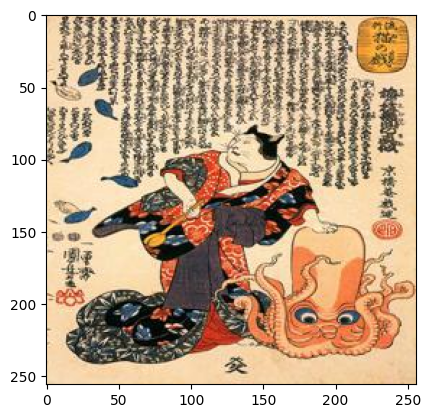

In [11]:
# Assuming 'ds' is your DatasetDict
image = ds["test"]["image"][42]
# Convert PIL.Image.Image to NumPy array
image_np = np.array(image)
# Transpose the dimensions
plt.imshow(image_np.transpose(1, 2, 0))
plt.show()

# Autoencoder


## Encoders

### Basic encoder

In [12]:
class Encoder(nn.Module):
    @staticmethod
    def conv_block(in_size: int, out_size: int):
        return nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_size),
            nn.LeakyReLU(),
        )

    def __init__(self, latent_width: int = 64, **kwargs) -> None:
        super().__init__()
        self.latent_width = latent_width

        self.model = nn.Sequential(
            Encoder.conv_block(1, 8),
            Encoder.conv_block(8, 8),
            Encoder.conv_block(8, 16),
            Encoder.conv_block(16, 16),
        )

        self.fc = nn.Sequential(
            nn.Linear(16 * 2 * 2, self.latent_width),
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        # x = torch.flatten(x, start_dim=1)
        x = einops.rearrange(x, "b c w h -> b (c w h)")
        x = self.fc(x)
        return x

### Variance Encoder

In [13]:
class Encoder(nn.Module):
    @staticmethod
    def conv_block(in_size: int, out_size: int):
        return nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_size),
            nn.LeakyReLU(),
        )

    def __init__(self, latent_width: int = 64, **kwargs) -> None:
        super().__init__()
        self.latent_width = latent_width

        self.model = nn.Sequential(
            Encoder.conv_block(1, 8),
            Encoder.conv_block(8, 8),
            Encoder.conv_block(8, 16),
            Encoder.conv_block(16, 16),
        )

        self.fc_mu = nn.Linear(16 * 2 * 2, self.latent_width)
        self.fc_logvar = nn.Linear(16 * 2 * 2, self.latent_width)

    def reparametrize(self, mean: torch.Tensor, logvariance: torch.Tensor):
        # transform N(0,1) into N(mean, variance)
        std_dev = torch.exp(0.5 * logvariance)
        eps = torch.randn_like(std_dev)
        return eps * std_dev + mean

    def encode(self, x: torch.Tensor):
        x = self.model(x)
        x = einops.rearrange(x, "b c w h -> b (c w h)")
        mean = self.fc_mu(x)
        logvariance = self.fc_logvar(x)
        return mean, logvariance

    def forward(self, x: torch.Tensor):
        mean, logvariance = self.encode(x)
        z = self.reparametrize(mean, logvariance)
        return z, mean, logvariance

### Loss function for variance encoder

In [14]:
def kld_loss_func(mean, logvariance):
    # distance from normal distribution

    # commonly seen version:
    # return torch.mean(
    #     -0.5 * torch.sum(1 + logvariance - mean**2 - logvariance.exp(), dim=1),
    #     dim=0,
    # )

    loss = einops.reduce(
        1 + logvariance - mean**2 - torch.exp(logvariance),
        "batch latent -> batch",
        "sum",
    )
    return einops.reduce(-0.5 * loss, "batch -> ()", "mean")


## Decoder

In [15]:
class Decoder(nn.Module):
    @staticmethod
    def conv_block(in_size: int, out_size: int):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_size,
                out_size,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(out_size),
            nn.LeakyReLU(),
        )

    def __init__(self, latent_width: int = 64, **kwargs) -> None:
        super().__init__()
        self.latent_width = latent_width

        self.fc = nn.Sequential(
            nn.Linear(self.latent_width, 16 * 2 * 2),
            nn.ReLU(),
        )
        self.model = nn.Sequential(
            Decoder.conv_block(16, 16),
            Decoder.conv_block(16, 8),
            Decoder.conv_block(8, 8),
            Decoder.conv_block(8, 8),
            nn.Conv2d(8, 1, kernel_size=5, stride=1, padding=0),
            # end result is an image, it must be in [0, 1] range!
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        x = self.fc(x)
        # x = torch.reshape(x, (-1, 16, 2, 2))
        x = einops.rearrange(x, "b (c w h) -> b c w h", c=16, w=2, h=2)
        x = self.model(x)
        return x

## Autoencoder

In [16]:
class Autoencoder(nn.Module):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        *args,
        **kwargs,
    ) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images: torch.Tensor):
        latent = self.encoder(images)
        decoded = self.decoder(latent)

        return decoded, latent